# Pending Tx Snapshots

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import datetime
import scipy

In [2]:
# read in sample.csv into a dataframe with \t delimiter
df = pd.read_csv('sample.csv', sep='\t')
print("Dataset shape: ", df.shape)
df.head()

Dataset shape:  (403212, 27)


,detecttime,hash,status,region,reorg,replace,curblocknumber,failurereason,blockspending,timepending,...,network,type,maxpriorityfeepergas,maxfeepergas,basefeepergas,dropreason,rejectionreason,stuck,gasused,detect_date
0,2023-02-24T00:00:00.167Z,0x2b7cd2e8fd547f4ef784e6713a8c06926a0ff1ced45b...,pending,us-east-1,NaN,NaN,16694512,none,NaN,NaN,...,main,2,3.000000e+09,4.702304e+10,28122281784,NaN,NaN,False,-1.0,2023-02-24
1,2023-02-24T00:00:00.253Z,0x2b7cd2e8fd547f4ef784e6713a8c06926a0ff1ced45b...,pending,eu-central-1,NaN,NaN,16694512,none,NaN,NaN,...,main,2,3.000000e+09,4.702304e+10,28122281784,NaN,NaN,False,-1.0,2023-02-24
2,2023-02-24T00:00:00.280Z,0x2b7cd2e8fd547f4ef784e6713a8c06926a0ff1ced45b...,pending,ap-southeast-1,NaN,NaN,16694512,none,NaN,NaN,...,main,2,3.000000e+09,4.702304e+10,28122281784,NaN,NaN,False,-1.0,2023-02-24
3,2023-02-24T00:00:00.374Z,0x44bfc98df9a35e3cd4f144bba9e89afdb12122747dda...,pending,eu-central-1,NaN,NaN,16694512,none,NaN,NaN,...,main,2,1.000000e+09,4.604646e+10,28122281784,NaN,NaN,False,-1.0,2023-02-24
4,2023-02-24T00:00:00.383Z,0x44bfc98df9a35e3cd4f144bba9e89afdb12122747dda...,pending,us-east-1,NaN,NaN,16694512,none,NaN,NaN,...,main,2,1.000000e+09,4.604646e+10,28122281784,NaN,NaN,False,-1.0,2023-02-24


In [4]:
# keep only the rows where region == 'us-east-1'
df_us = df[df['region'] == 'us-east-1']

In [5]:
# add datetime column to df_us, where datetime is the datetime representation of detecttime
df_us['datetime'] = pd.to_datetime(df_us['detecttime'])

/var/folders/5j/sp7zw9k97sdfqkf7m2vn2m4h0000gn/T/ipykernel_84438/789236403.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_us['datetime'] = pd.to_datetime(df_us['detecttime'])


## Snapshot at 0:59:59 
(at the end of our dataset)

In [6]:
# for each row, if the status != pending, add the hash to the list 
not_pending_hashes = []
for index, row in df_us.iterrows():
    if row['status'] != 'pending':
        not_pending_hashes.append(row['hash'])

In [7]:
# keep only the rows where hash is not in not_pending_hashes
df_us_pending = df_us[~df_us['hash'].isin(not_pending_hashes)]

In [8]:
## Sanity check ##
# get the unique status in df_us_pending
print("Unique status in df_us_pending: ", df_us_pending['status'].unique())
# get shape of df_us_pending
print("Shape of df_us_pending: ", df_us_pending.shape)

Unique status in df_us_pending:  ['pending']
Shape of df_us_pending:  (585, 28)


In [14]:
# get the detecttime of the last row in df
last_detecttime = df_us.iloc[-1]['datetime']

# create a new column in df_us_pending called total_pending_time that is the difference between last_detecttime and detecttime
df_us_pending['total_pending_time'] = last_detecttime - df_us_pending['datetime']

# create a new column "floattime" in df_us_pending that converts the total_pending_time column to float in seconds
df_us_pending['floattime'] = df_us_pending['total_pending_time'].dt.total_seconds()

# get num of rows in df_us_pending with floattime <= 0
num_rows = df_us_pending[df_us_pending['floattime'] < 0].shape[0]
print("\nNumber of rows with floattime < 0: ", num_rows, "\n\n")


Number of rows with floattime < 0:  0 




/var/folders/5j/sp7zw9k97sdfqkf7m2vn2m4h0000gn/T/ipykernel_84438/1048035597.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_us_pending['total_pending_time'] = last_detecttime - df_us_pending['datetime']
/var/folders/5j/sp7zw9k97sdfqkf7m2vn2m4h0000gn/T/ipykernel_84438/1048035597.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_us_pending['floattime'] = df_us_pending['total_pending_time'].dt.total_seconds()


In [15]:
# print the first and last 5 columns 'detecttime' 'datetime' 'total_pending_time' 'floattime'
print("head:")
print(df_us_pending[['detecttime', 'datetime', 'total_pending_time', 'floattime']].head())
print("\n\n\ntail:")
print(df_us_pending[['detecttime', 'datetime', 'total_pending_time', 'floattime']].tail())

head:
                    detecttime                         datetime  \
105   2023-02-24T00:00:02.590Z 2023-02-24 00:00:02.590000+00:00   
651   2023-02-24T00:00:08.876Z 2023-02-24 00:00:08.876000+00:00   
1281  2023-02-24T00:00:12.795Z 2023-02-24 00:00:12.795000+00:00   
6330  2023-02-24T00:00:42.090Z 2023-02-24 00:00:42.090000+00:00   
7365  2023-02-24T00:00:51.786Z 2023-02-24 00:00:51.786000+00:00   

         total_pending_time  floattime  
105  0 days 00:59:57.233000   3597.233  
651  0 days 00:59:50.947000   3590.947  
1281 0 days 00:59:47.028000   3587.028  
6330 0 days 00:59:17.733000   3557.733  
7365 0 days 00:59:08.037000   3548.037  



tail:
                      detecttime                         datetime  \
403193  2023-02-24T00:59:59.187Z 2023-02-24 00:59:59.187000+00:00   
403199  2023-02-24T00:59:59.375Z 2023-02-24 00:59:59.375000+00:00   
403204  2023-02-24T00:59:59.496Z 2023-02-24 00:59:59.496000+00:00   
403208  2023-02-24T00:59:59.711Z 2023-02-24 00:59:59.711000+

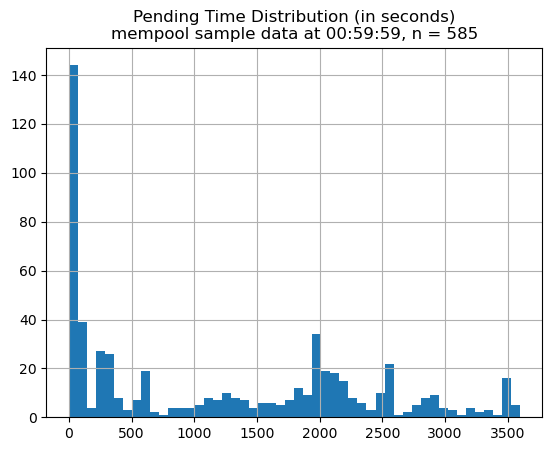

Mean:	 1187.0818512820513 seconds
Median:	 1053.25 seconds
Mode:	 0     320.429
1    1974.105
Name: floattime, dtype: float64


In [34]:
num_rows = df_us_pending.shape[0]

#graph the distribution of floattime 
df_us_pending['floattime'].hist(bins=50)
plt.title("Pending Time Distribution (in seconds)\nmempool sample data at 00:59:59, n = "+ str(num_rows))
plt.show()
plt.close()

# get the mean, median, and mode of floattime
print("Mean:\t",    df_us_pending['floattime'].mean(), "seconds")
print("Median:\t",  df_us_pending['floattime'].median(), "seconds")
print("Mode:\t",    df_us_pending['floattime'].mode())

/var/folders/5j/sp7zw9k97sdfqkf7m2vn2m4h0000gn/T/ipykernel_84438/2805829008.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_us_pending['floattime'], hist=False, label='floattime')


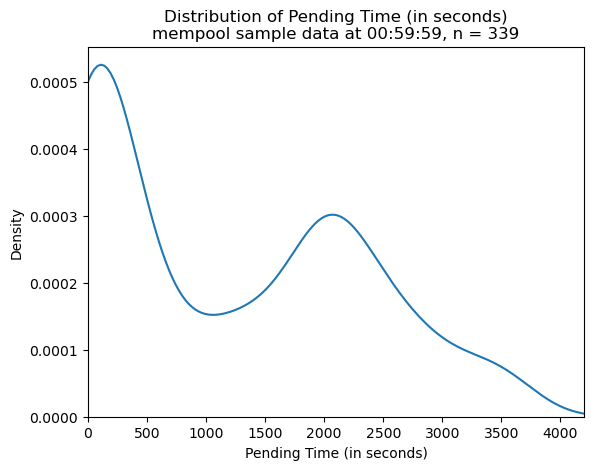

In [71]:
# plot the distribution of floattime with seaborn
sns.distplot(df_us_pending['floattime'], hist=False, label='floattime')
plt.xlim(0, 4200)
plt.title("Distribution of Pending Time (in seconds)\nmempool sample data at 00:59:59, n = "+ str(num_rows))
plt.xlabel("Pending Time (in seconds)")
plt.ylabel("Density")
plt.show()
plt.close()

/var/folders/5j/sp7zw9k97sdfqkf7m2vn2m4h0000gn/T/ipykernel_84438/1303961125.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_us_pending['floattime'], hist=True, label='floattime')


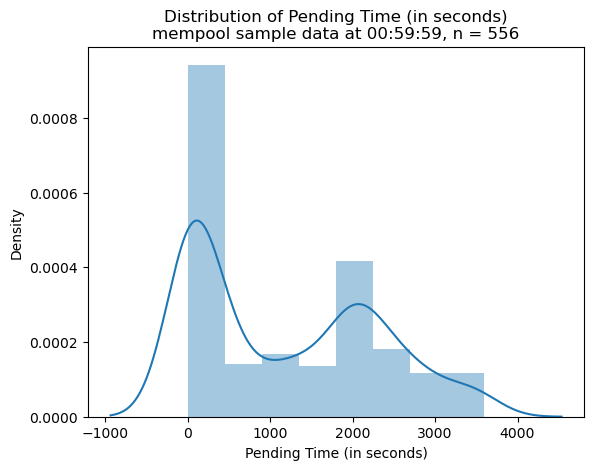

In [37]:
# plot the distribution of floattime
sns.distplot(df_us_pending['floattime'], hist=True, label='floattime')
plt.title("Distribution of Pending Time (in seconds)\nmempool sample data at 00:59:59, n = "+ str(num_rows))
plt.xlabel("Pending Time (in seconds)")
plt.ylabel("Density")
plt.show()
plt.close()

/Users/tara/opt/anaconda3/envs/camcos/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


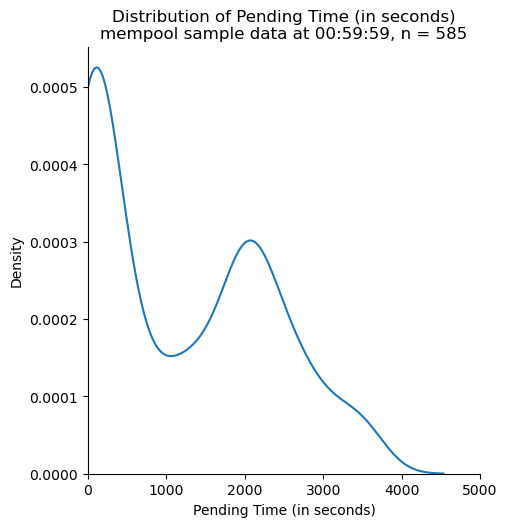

In [22]:
# model the distribution of floattime with sns.displot 
sns.displot(df_us_pending['floattime'], kind='kde')
# set xlim to 0, 5000
plt.xlim(0, 5000)
plt.title("Distribution of Pending Time (in seconds)\nmempool sample data at 00:59:59, n = "+ str(num_rows))
plt.xlabel("Pending Time (in seconds)")
plt.ylabel("Density")
plt.show()


In [23]:
# get the 80% confidence interval of floattime
print("85% confidence interval: ", scipy.stats.norm.interval(0.80, loc=df_us_pending['floattime'].mean(), scale=df_us_pending['floattime'].std()))

# get the 90% confidence interval of floattime
print("90% confidence interval: ", scipy.stats.norm.interval(0.90, loc=df_us_pending['floattime'].mean(), scale=df_us_pending['floattime'].std()))

# get the 95% confidence interval of floattime
print("95% confidence interval: ", scipy.stats.norm.interval(0.95, loc=df_us_pending['floattime'].mean(), scale=df_us_pending['floattime'].std()))

# get the 99% confidence interval of floattime
print("99% confidence interval: ", scipy.stats.norm.interval(0.99, loc=df_us_pending['floattime'].mean(), scale=df_us_pending['floattime'].std()))

85% confidence interval:  (-242.12695910245475, 2616.2906616665573)
90% confidence interval:  (-647.2877976933735, 3021.4515002574753)
95% confidence interval:  (-998.7044019231305, 3372.868104487233)
99% confidence interval:  (-1685.528220490012, 4059.6919230541143)


## Snapshot at 0:49:59

In [24]:
# make a new DF called snapshot 49, where the datetime is < 2023-02-24 00:50:00.000000+00:00
snapshot_49 = df_us[df_us['datetime'] < '2023-02-24 00:50:00.000000+00:00']

print(snapshot_49['datetime'].tail())

341388   2023-02-24 00:49:59.551000+00:00
341389   2023-02-24 00:49:59.551000+00:00
341397   2023-02-24 00:49:59.831000+00:00
341399   2023-02-24 00:49:59.940000+00:00
341400   2023-02-24 00:49:59.969000+00:00
Name: datetime, dtype: datetime64[ns, UTC]


In [25]:
# for each row, if the status != pending, add the hash to the list 
not_pending_hashes = []
for index, row in snapshot_49.iterrows():
    if row['status'] != 'pending':
        not_pending_hashes.append(row['hash'])

# keep only the rows where hash is not in not_pending_hashes
snapshot_49_pending = snapshot_49[~snapshot_49['hash'].isin(not_pending_hashes)]


## Sanity check ##
print("Unique status in snapshot_49_pending: ", snapshot_49_pending['status'].unique())
print("Shape of snapshot_49_pending: ", snapshot_49_pending.shape)

Unique status in snapshot_49_pending:  ['pending']
Shape of snapshot_49_pending:  (556, 28)


In [27]:
# get the detecttime of the last row
last_detecttime = snapshot_49.iloc[-1]['datetime']

# create a new column called total_pending_time that is the difference between last_detecttime and detecttime
snapshot_49_pending['total_pending_time'] = last_detecttime - snapshot_49_pending['datetime']

# create a new column "floattime" in that converts the total_pending_time column to float in seconds
snapshot_49_pending['floattime'] = snapshot_49_pending['total_pending_time'].dt.total_seconds()

# get num of rows with floattime <= 0
num_rows = snapshot_49_pending[snapshot_49_pending['floattime'] < 0].shape[0]
print("\nNumber of rows with floattime < 0: ", num_rows, "\n\n")


Number of rows with floattime < 0:  0 




/var/folders/5j/sp7zw9k97sdfqkf7m2vn2m4h0000gn/T/ipykernel_84438/1899243339.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snapshot_49_pending['total_pending_time'] = last_detecttime - snapshot_49_pending['datetime']
/var/folders/5j/sp7zw9k97sdfqkf7m2vn2m4h0000gn/T/ipykernel_84438/1899243339.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snapshot_49_pending['floattime'] = snapshot_49_pending['total_pending_time'].dt.total_seconds()


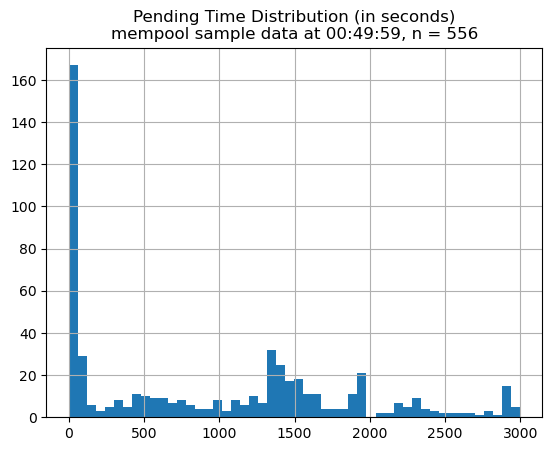

Mean:	 932.7190017985612 seconds
Median:	 811.2375 seconds
Mode:	 0    1374.251
Name: floattime, dtype: float64


In [35]:
num_rows = snapshot_49_pending.shape[0]

# graph floattime 
snapshot_49_pending['floattime'].hist(bins=50)
plt.title("Pending Time Distribution (in seconds)\nmempool sample data at 00:49:59, n = "+ str(num_rows))
plt.show()
plt.close()


# get the mean, median, and mode of floattime
print("Mean:\t",     snapshot_49_pending['floattime'].mean(), "seconds")
print("Median:\t",   snapshot_49_pending['floattime'].median(), "seconds")
print("Mode:\t",     snapshot_49_pending['floattime'].mode())

/var/folders/5j/sp7zw9k97sdfqkf7m2vn2m4h0000gn/T/ipykernel_84438/3485520716.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(snapshot_49_pending['floattime'], hist=False, label='floattime')


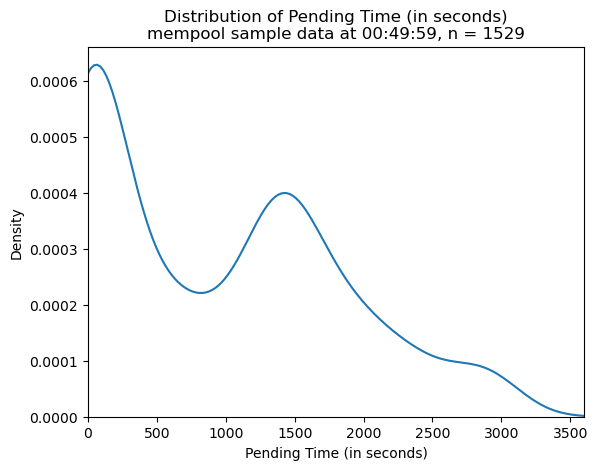

In [60]:
# plot the distribution of floattime with seaborn
sns.distplot(snapshot_49_pending['floattime'], hist=False, label='floattime')
plt.xlim(0, 3600)
plt.title("Distribution of Pending Time (in seconds)\nmempool sample data at 00:49:59, n = "+ str(num_rows))
plt.xlabel("Pending Time (in seconds)")
plt.ylabel("Density")
plt.show()
plt.close()

/var/folders/5j/sp7zw9k97sdfqkf7m2vn2m4h0000gn/T/ipykernel_84438/3814886841.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(snapshot_49_pending['floattime'], hist=True, label='floattime')


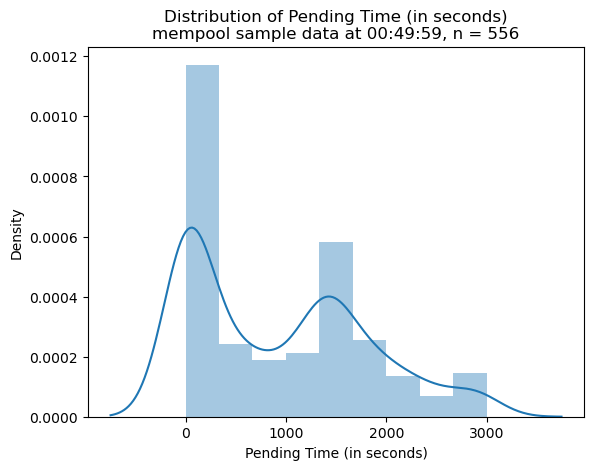

In [40]:
# plot the distribution of floattime
sns.distplot(snapshot_49_pending['floattime'], hist=True, label='floattime')
plt.title("Distribution of Pending Time (in seconds)\nmempool sample data at 00:49:59, n = "+ str(num_rows))
plt.xlabel("Pending Time (in seconds)")
plt.ylabel("Density")
plt.show()
plt.close()

## Snapshot at 0:39:59

In [41]:
# make a new DF called snapshot 39, where the datetime is < 2023-02-24 00:40:00.000000+00:00
snapshot_39 = df_us[df_us['datetime'] < '2023-02-24 00:40:00.000000+00:00']

print(snapshot_39['datetime'].tail())

278511   2023-02-24 00:39:59.990000+00:00
278512   2023-02-24 00:39:59.990000+00:00
278513   2023-02-24 00:39:59.990000+00:00
278514   2023-02-24 00:39:59.990000+00:00
278515   2023-02-24 00:39:59.990000+00:00
Name: datetime, dtype: datetime64[ns, UTC]


In [42]:
# for each row, if the status != pending, add the hash to the list 
not_pending_hashes = []
for index, row in snapshot_39.iterrows():
    if row['status'] != 'pending':
        not_pending_hashes.append(row['hash'])

# keep only the rows where hash is not in not_pending_hashes
snapshot_39_pending = snapshot_39[~snapshot_39['hash'].isin(not_pending_hashes)]


## Sanity check ##
print("Unique status in snapshot_39_pending: ", snapshot_39_pending['status'].unique())
print("Shape of snapshot_39_pending: ", snapshot_39_pending.shape)

Unique status in snapshot_39_pending:  ['pending']
Shape of snapshot_39_pending:  (509, 28)


In [43]:
# get the detecttime of the last row 
last_detecttime = snapshot_39.iloc[-1]['datetime']

# create a new column called total_pending_time that is the difference between last_detecttime and detecttime
snapshot_39_pending['total_pending_time'] = last_detecttime - snapshot_39_pending['datetime']

# create a new column "floattime" that converts the total_pending_time column to float in seconds
snapshot_39_pending['floattime'] = snapshot_39_pending['total_pending_time'].dt.total_seconds()

# get num of rows with floattime <= 0
num_rows = snapshot_39_pending[snapshot_39_pending['floattime'] < 0].shape[0]
print("\nNumber of rows with floattime < 0: ", num_rows, "\n\n")


Number of rows with floattime < 0:  0 




/var/folders/5j/sp7zw9k97sdfqkf7m2vn2m4h0000gn/T/ipykernel_84438/4209534.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snapshot_39_pending['total_pending_time'] = last_detecttime - snapshot_39_pending['datetime']
/var/folders/5j/sp7zw9k97sdfqkf7m2vn2m4h0000gn/T/ipykernel_84438/4209534.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snapshot_39_pending['floattime'] = snapshot_39_pending['total_pending_time'].dt.total_seconds()


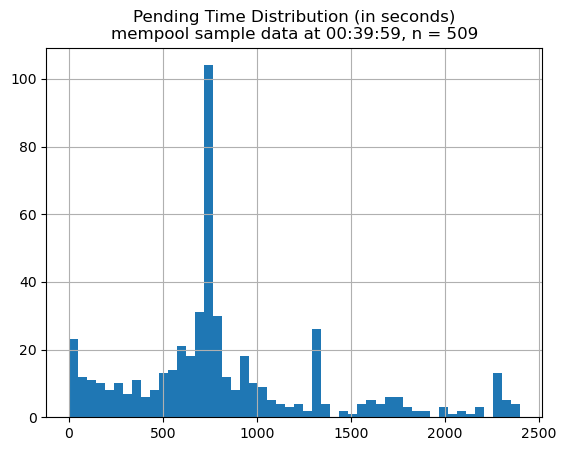

Mean:	 836.6437858546168 seconds
Median:	 732.145 seconds
Mode:	 0    774.272
Name: floattime, dtype: float64


In [44]:
num_rows = snapshot_39_pending.shape[0]

#graph the distribution of floattime 
snapshot_39_pending['floattime'].hist(bins=50)
plt.title("Pending Time Distribution (in seconds)\nmempool sample data at 00:39:59, n = "+ str(num_rows))
plt.show()
plt.close()


# get the mean, median, and mode of floattime
print("Mean:\t",     snapshot_39_pending['floattime'].mean(), "seconds")
print("Median:\t",   snapshot_39_pending['floattime'].median(), "seconds")
print("Mode:\t",     snapshot_39_pending['floattime'].mode())

/var/folders/5j/sp7zw9k97sdfqkf7m2vn2m4h0000gn/T/ipykernel_84438/2354679992.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(snapshot_39_pending['floattime'], hist=False, label='floattime')


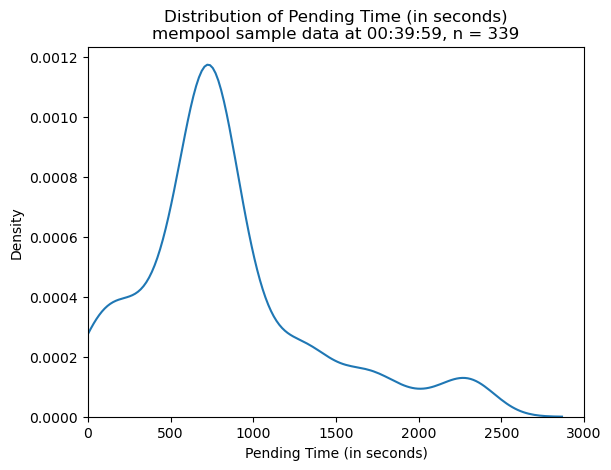

In [72]:
# plot the distribution of floattime with seaborn
sns.distplot(snapshot_39_pending['floattime'], hist=False, label='floattime')
plt.xlim(0, 3000)
plt.title("Distribution of Pending Time (in seconds)\nmempool sample data at 00:39:59, n = "+ str(num_rows))
plt.xlabel("Pending Time (in seconds)")
plt.ylabel("Density")
plt.show()
plt.close()

/var/folders/5j/sp7zw9k97sdfqkf7m2vn2m4h0000gn/T/ipykernel_84438/3711482109.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(snapshot_39_pending['floattime'], hist=True, label='floattime')


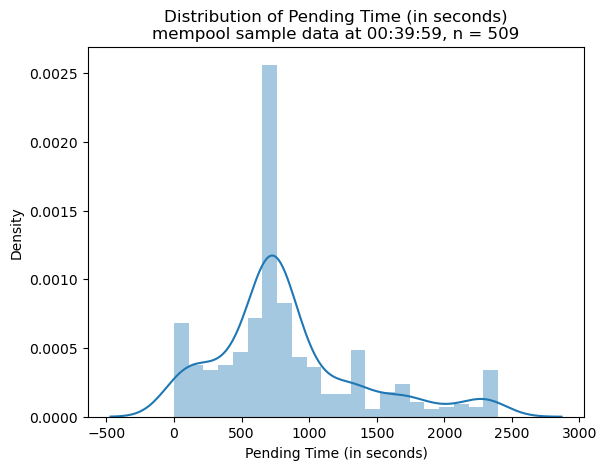

In [46]:
# plot the distribution of floattime
sns.distplot(snapshot_39_pending['floattime'], hist=True, label='floattime')
plt.title("Distribution of Pending Time (in seconds)\nmempool sample data at 00:39:59, n = "+ str(num_rows))
plt.xlabel("Pending Time (in seconds)")
plt.ylabel("Density")
plt.show()
plt.close()

## Snapshot at 0:29:59

In [ ]:
# make a new DF called snapshot 29, where the datetime is < 2023-02-24 00:30:00.000000+00:00
snapshot_29 = df_us[df_us['datetime'] < '2023-02-24 00:30:00.000000+00:00']

print(snapshot_29['datetime'].tail())

216434   2023-02-24 00:29:59.870000+00:00
216439   2023-02-24 00:29:59.887000+00:00
216443   2023-02-24 00:29:59.922000+00:00
216445   2023-02-24 00:29:59.924000+00:00
216451   2023-02-24 00:29:59.975000+00:00
Name: datetime, dtype: datetime64[ns, UTC]


In [ ]:
# for each row, if the status != pending, add the hash to the list 
not_pending_hashes = []
for index, row in snapshot_29.iterrows():
    if row['status'] != 'pending':
        not_pending_hashes.append(row['hash'])

# keep only the rows where hash is not in not_pending_hashes
snapshot_29_pending = snapshot_29[~snapshot_29['hash'].isin(not_pending_hashes)]


## Sanity check ##
print("Unique status in snapshot_29_pending: ", snapshot_29_pending['status'].unique())
print("Shape of snapshot_29_pending: ", snapshot_29_pending.shape)

Unique status in snapshot_29_pending:  ['pending']
Shape of snapshot_29_pending:  (1529, 28)


In [ ]:
# get the detecttime of the last row in df
last_detecttime = snapshot_29.iloc[-1]['datetime']

# create a new column called total_pending_time that is the difference between last_detecttime and detecttime
snapshot_29_pending['total_pending_time'] = last_detecttime - snapshot_29_pending['datetime']

# create a new column "floattime" that converts the total_pending_time column to float in seconds
snapshot_29_pending['floattime'] = snapshot_29_pending['total_pending_time'].dt.total_seconds()

# get num of rows with floattime <= 0
num_rows = snapshot_29_pending[snapshot_29_pending['floattime'] < 0].shape[0]
print("\nNumber of rows with floattime < 0: ", num_rows, "\n\n")


Number of rows with floattime < 0:  0 




/var/folders/5j/sp7zw9k97sdfqkf7m2vn2m4h0000gn/T/ipykernel_84438/3233072520.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snapshot_29_pending['total_pending_time'] = last_detecttime - snapshot_29_pending['datetime']
/var/folders/5j/sp7zw9k97sdfqkf7m2vn2m4h0000gn/T/ipykernel_84438/3233072520.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snapshot_29_pending['floattime'] = snapshot_29_pending['total_pending_time'].dt.total_seconds()


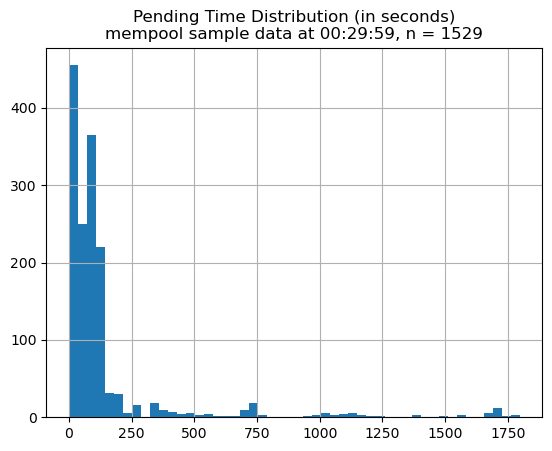

Mean:	 153.8165376062786 seconds
Median:	 80.938 seconds
Mode:	 0    174.257
Name: floattime, dtype: float64


In [ ]:
num_rows = snapshot_29_pending.shape[0]

#graph the distribution of floattime 
snapshot_29_pending['floattime'].hist(bins=50)
plt.title("Pending Time Distribution (in seconds)\nmempool sample data at 00:29:59, n = "+ str(num_rows))
plt.show()
plt.close()


# get the mean, median, and mode of floattime
print("Mean:\t",     snapshot_29_pending['floattime'].mean(), "seconds")
print("Median:\t",   snapshot_29_pending['floattime'].median(), "seconds")
print("Mode:\t",     snapshot_29_pending['floattime'].mode())

/var/folders/5j/sp7zw9k97sdfqkf7m2vn2m4h0000gn/T/ipykernel_84438/2216856468.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(snapshot_29_pending['floattime'], hist=False, label='floattime')


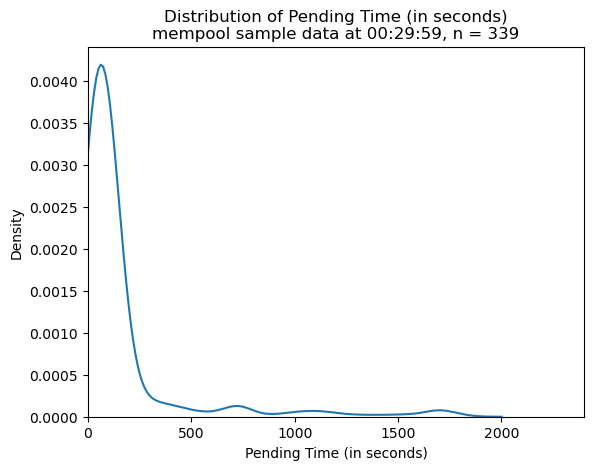

In [73]:
# plot the distribution of floattime with seaborn
sns.distplot(snapshot_29_pending['floattime'], hist=False, label='floattime')
plt.xlim(0, 2400)
plt.title("Distribution of Pending Time (in seconds)\nmempool sample data at 00:29:59, n = "+ str(num_rows))
plt.xlabel("Pending Time (in seconds)")
plt.ylabel("Density")
plt.show()
plt.close()

/var/folders/5j/sp7zw9k97sdfqkf7m2vn2m4h0000gn/T/ipykernel_84438/2962918505.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(snapshot_29_pending['floattime'], hist=True, label='floattime')


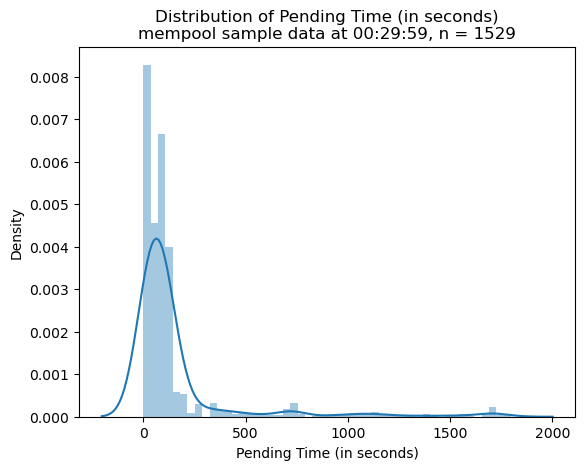

In [ ]:
# plot the distribution of floattime
sns.distplot(snapshot_29_pending['floattime'], hist=True, label='floattime')
plt.title("Distribution of Pending Time (in seconds)\nmempool sample data at 00:29:59, n = "+ str(num_rows))
plt.xlabel("Pending Time (in seconds)")
plt.ylabel("Density")
plt.show()
plt.close()

## Snapshot at 0:19:59

In [63]:
# make a new DF called snapshot 19, where the datetime is < 2023-02-24 00:20:00.000000+00:00
snapshot_19 = df_us[df_us['datetime'] < '2023-02-24 00:20:00.000000+00:00']

print(snapshot_19['datetime'].tail())

134391   2023-02-24 00:19:59.117000+00:00
134395   2023-02-24 00:19:59.623000+00:00
134398   2023-02-24 00:19:59.704000+00:00
134399   2023-02-24 00:19:59.704000+00:00
134401   2023-02-24 00:19:59.948000+00:00
Name: datetime, dtype: datetime64[ns, UTC]


In [64]:
# for each row, if the status != pending, add the hash to the list 
not_pending_hashes = []
for index, row in snapshot_19.iterrows():
    if row['status'] != 'pending':
        not_pending_hashes.append(row['hash'])

# keep only the rows where hash is not in not_pending_hashes
snapshot_19_pending = snapshot_19[~snapshot_19['hash'].isin(not_pending_hashes)]


## Sanity check ##
print("Unique status in snapshot_19_pending: ", snapshot_19_pending['status'].unique())
print("Shape of snapshot_19_pending: ", snapshot_19_pending.shape)

Unique status in snapshot_19_pending:  ['pending']
Shape of snapshot_19_pending:  (339, 28)


In [65]:
# get the detecttime of the last row
last_detecttime = snapshot_19.iloc[-1]['datetime']

# create a new column called total_pending_time that is the difference between last_detecttime and detecttime
snapshot_19_pending['total_pending_time'] = last_detecttime - snapshot_19_pending['datetime']

# create a new column "floattime" that converts the total_pending_time column to float in seconds
snapshot_19_pending['floattime'] = snapshot_19_pending['total_pending_time'].dt.total_seconds()

# get num of rows with floattime <= 0
num_rows = snapshot_19_pending[snapshot_19_pending['floattime'] < 0].shape[0]
print("\nNumber of rows with floattime < 0: ", num_rows, "\n\n")


Number of rows with floattime < 0:  0 




/var/folders/5j/sp7zw9k97sdfqkf7m2vn2m4h0000gn/T/ipykernel_84438/2017027961.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snapshot_19_pending['total_pending_time'] = last_detecttime - snapshot_19_pending['datetime']
/var/folders/5j/sp7zw9k97sdfqkf7m2vn2m4h0000gn/T/ipykernel_84438/2017027961.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snapshot_19_pending['floattime'] = snapshot_19_pending['total_pending_time'].dt.total_seconds()


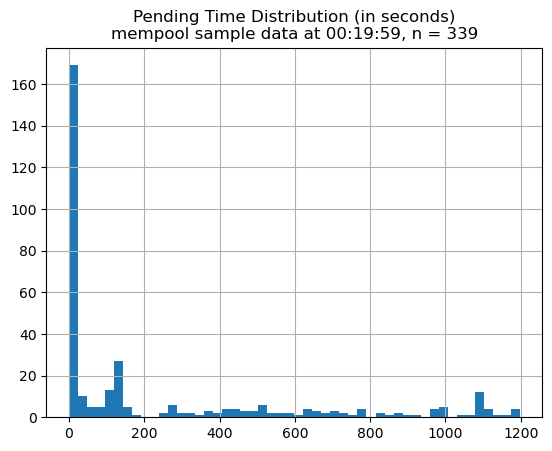

Mean:	 242.67800589970506 seconds
Median:	 24.395 seconds
Mode:	 0     123.576
1    1090.204
Name: floattime, dtype: float64


In [66]:
num_rows = snapshot_19_pending.shape[0]

#graph the distribution of floattime 
snapshot_19_pending['floattime'].hist(bins=50)
plt.title("Pending Time Distribution (in seconds)\nmempool sample data at 00:19:59, n = "+ str(num_rows))
plt.show()
plt.close()


# get the mean, median, and mode of floattime
print("Mean:\t",     snapshot_19_pending['floattime'].mean(), "seconds")
print("Median:\t",   snapshot_19_pending['floattime'].median(), "seconds")
print("Mode:\t",     snapshot_19_pending['floattime'].mode())

/var/folders/5j/sp7zw9k97sdfqkf7m2vn2m4h0000gn/T/ipykernel_84438/4046189541.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(snapshot_19_pending['floattime'], hist=False, label='floattime')


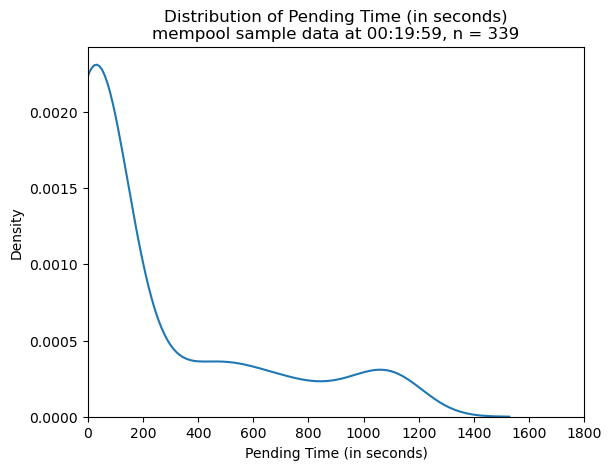

In [74]:
# plot the distribution of floattime with seaborn
sns.distplot(snapshot_19_pending['floattime'], hist=False, label='floattime')
plt.xlim(0, 1800)
plt.title("Distribution of Pending Time (in seconds)\nmempool sample data at 00:19:59, n = "+ str(num_rows))
plt.xlabel("Pending Time (in seconds)")
plt.ylabel("Density")
plt.show()
plt.close()

/var/folders/5j/sp7zw9k97sdfqkf7m2vn2m4h0000gn/T/ipykernel_84438/2403684319.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(snapshot_19_pending['floattime'], hist=True, label='floattime')


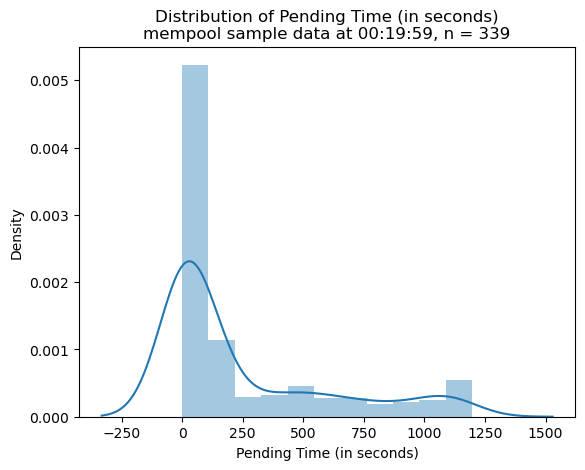

In [68]:
# plot the distribution of floattime
sns.distplot(snapshot_19_pending['floattime'], hist=True, label='floattime')
plt.title("Distribution of Pending Time (in seconds)\nmempool sample data at 00:19:59, n = "+ str(num_rows))
plt.xlabel("Pending Time (in seconds)")
plt.ylabel("Density")
plt.show()
plt.close()

# Snapshot at 0:09:59

In [75]:
# make a new DF called snapshot 19, where the datetime is < 2023-02-24 00:10:00.000000+00:00
snapshot_09 = df_us[df_us['datetime'] < '2023-02-24 00:10:00.000000+00:00']

print(snapshot_09['datetime'].tail())

71968   2023-02-24 00:09:59.919000+00:00
71969   2023-02-24 00:09:59.921000+00:00
71970   2023-02-24 00:09:59.922000+00:00
71971   2023-02-24 00:09:59.922000+00:00
71972   2023-02-24 00:09:59.957000+00:00
Name: datetime, dtype: datetime64[ns, UTC]


In [76]:
# for each row, if the status != pending, add the hash to the list 
not_pending_hashes = []
for index, row in snapshot_09.iterrows():
    if row['status'] != 'pending':
        not_pending_hashes.append(row['hash'])

# keep only the rows where hash is not in not_pending_hashes
snapshot_09_pending = snapshot_09[~snapshot_09['hash'].isin(not_pending_hashes)]


## Sanity check ##
print("Unique status in snapshot_09_pending: ", snapshot_09_pending['status'].unique())
print("Shape of snapshot_09_pending: ", snapshot_09_pending.shape)

Unique status in snapshot_09_pending:  ['pending']
Shape of snapshot_09_pending:  (231, 28)


In [77]:
# get the detecttime of the last row 
last_detecttime = snapshot_09.iloc[-1]['datetime']

# create a new column called total_pending_time that is the difference between last_detecttime and detecttime
snapshot_09_pending['total_pending_time'] = last_detecttime - snapshot_09_pending['datetime']

# create a new column "floattime" that converts the total_pending_time column to float in seconds
snapshot_09_pending['floattime'] = snapshot_09_pending['total_pending_time'].dt.total_seconds()

# get num of rows with floattime <= 0
num_rows = snapshot_09_pending[snapshot_09_pending['floattime'] < 0].shape[0]
print("\nNumber of rows with floattime < 0: ", num_rows, "\n\n")


Number of rows with floattime < 0:  0 




/var/folders/5j/sp7zw9k97sdfqkf7m2vn2m4h0000gn/T/ipykernel_84438/2800153230.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snapshot_09_pending['total_pending_time'] = last_detecttime - snapshot_09_pending['datetime']
/var/folders/5j/sp7zw9k97sdfqkf7m2vn2m4h0000gn/T/ipykernel_84438/2800153230.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snapshot_09_pending['floattime'] = snapshot_09_pending['total_pending_time'].dt.total_seconds()


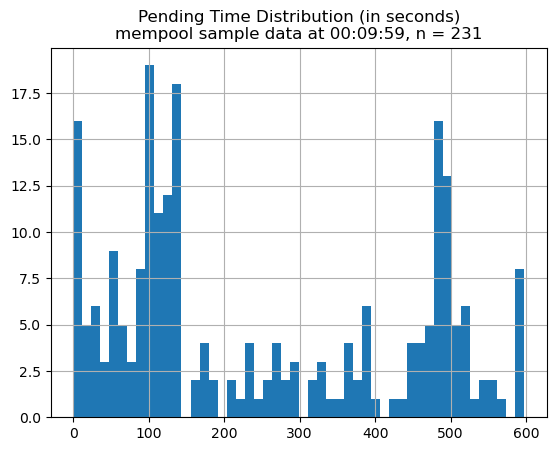

Mean:	 249.30175757575756 seconds
Median:	 156.574 seconds
Mode:	 0    490.213
Name: floattime, dtype: float64


In [78]:
num_rows = snapshot_09_pending.shape[0]

#graph the distribution of floattime 
snapshot_09_pending['floattime'].hist(bins=50)
plt.title("Pending Time Distribution (in seconds)\nmempool sample data at 00:09:59, n = "+ str(num_rows))
plt.show()
plt.close()


# get the mean, median, and mode of floattime
print("Mean:\t",     snapshot_09_pending['floattime'].mean(), "seconds")
print("Median:\t",   snapshot_09_pending['floattime'].median(), "seconds")
print("Mode:\t",     snapshot_09_pending['floattime'].mode())

/var/folders/5j/sp7zw9k97sdfqkf7m2vn2m4h0000gn/T/ipykernel_84438/1281740005.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(snapshot_09_pending['floattime'], hist=False, label='floattime')


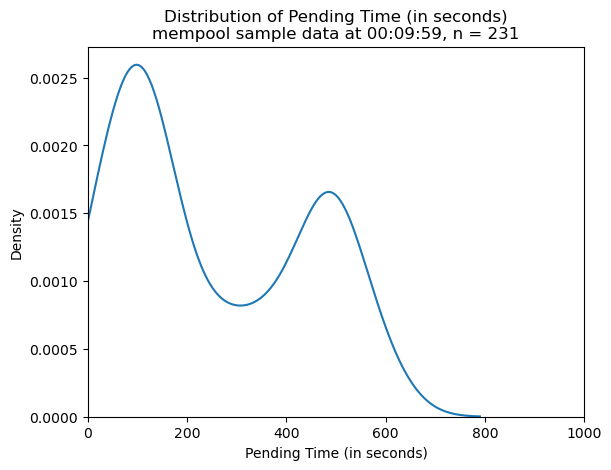

In [81]:
# plot the distribution of floattime with seaborn
sns.distplot(snapshot_09_pending['floattime'], hist=False, label='floattime')
plt.xlim(0, 1000)
plt.title("Distribution of Pending Time (in seconds)\nmempool sample data at 00:09:59, n = "+ str(num_rows))
plt.xlabel("Pending Time (in seconds)")
plt.ylabel("Density")
plt.show()
plt.close()

/var/folders/5j/sp7zw9k97sdfqkf7m2vn2m4h0000gn/T/ipykernel_84438/1951120313.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(snapshot_09_pending['floattime'], hist=True, label='floattime')


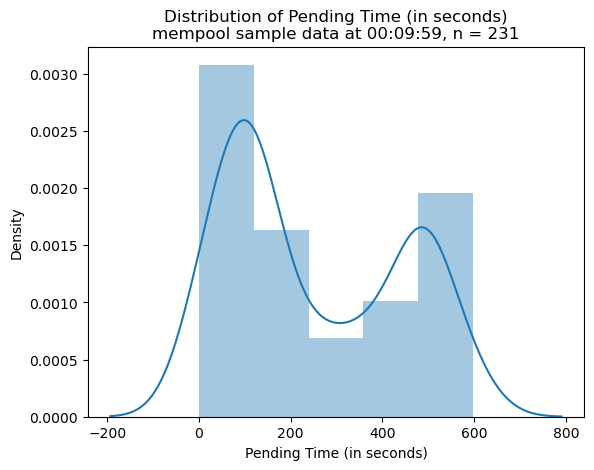

In [80]:
# plot the distribution of floattime
sns.distplot(snapshot_09_pending['floattime'], hist=True, label='floattime')
plt.title("Distribution of Pending Time (in seconds)\nmempool sample data at 00:09:59, n = "+ str(num_rows))
plt.xlabel("Pending Time (in seconds)")
plt.ylabel("Density")
plt.show()
plt.close()